# P6 - Notebook 3 : Étude de Faisabilité - Clustering Textuel

In [1]:
# ---
# ## Introduction
# Ce notebook évalue la faisabilité d'un moteur de classification en testant si les
# descriptions de produits peuvent être regroupées de manière cohérente via une
# approche non supervisée (clustering).
# ---

## 1. Imports et Chargement des Données

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer

# Charger les données textuelles nettoyées
df = pd.read_csv('Data/df_desc_cleaned.csv')

# Préparation des données
texts = df['cleaned_description'].astype(str).tolist()
true_labels_str = df['main_category'].astype(str)

# Encodage des vraies étiquettes pour l'évaluation
le = LabelEncoder()
true_labels = le.fit_transform(true_labels_str)
n_clusters = len(le.classes_)

## 2. Fonctions d'Évaluation du Clustering

In [3]:
results = {}

def evaluate_clustering(features, name):
    """Applique KMeans et stocke les scores ARI et NMI."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(features)

    ari = adjusted_rand_score(true_labels, clusters)
    nmi = normalized_mutual_info_score(true_labels, clusters)

    results[name] = {'ARI': ari, 'NMI': nmi}
    print(f"Résultats pour {name} -> ARI: {ari:.3f}, NMI: {nmi:.3f}")
    return features

def analyser_et_visualiser_clustering(features, nom_algorithme, true_labels_str, n_clusters):
    """
    Cette fonction réalise l'ensemble de l'analyse pour un algorithme de clustering :
    1. Exécute KMeans sur les features originales (haute dimension).
    2. Réduit la dimension des features à 2D avec ACP (uniquement pour la visualisation).
    3. Crée les graphiques et la matrice de contingence.
    """
    print(f"--- Analyse pour l'algorithme : {nom_algorithme} ---")

    # --- Étape 1 : Clustering sur les features originales (haute dimension) ---
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters_predits = kmeans.fit_predict(features)

    # --- Étape 2 : Réduction ACP UNIQUEMENT pour la visualisation en 2D ---
    pca = PCA(n_components=2, random_state=42)
    features_2d = pca.fit_transform(features)

    # --- Étape 3 : Création du DataFrame pour les graphiques ---
    # On combine les résultats des deux étapes précédentes.
    df_viz = pd.DataFrame({
        'x': features_2d[:, 0],
        'y': features_2d[:, 1],
        'true_category': true_labels_str,
        'predicted_cluster': clusters_predits.astype(str)
    })

    # --- Étape 4 : Graphique des Vraies catégories ---
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_viz, x='x', y='y', hue='true_category', palette='viridis', alpha=0.7)
    plt.title(f'Visualisation des Vraies Catégories (ACP sur {nom_algorithme})')
    plt.xlabel('Composante Principale 1')
    plt.ylabel('Composante Principale 2')
    plt.legend(title='Catégorie Réelle')
    plt.show()

    # --- Étape 5 : Graphique des clusters prédits ---
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_viz, x='x', y='y', hue='predicted_cluster', palette='viridis', alpha=0.7)
    plt.title(f'Clusters Prédits par KMeans (ACP sur {nom_algorithme})')
    plt.xlabel('Composante Principale 1')
    plt.ylabel('Composante Principale 2')
    plt.legend(title='Cluster Prédit')
    plt.show()

    # --- Étape 6 : Matrice de Contingence ---
    contingency_matrix = pd.crosstab(df_viz['true_category'], df_viz['predicted_cluster'])

    column_order = contingency_matrix.idxmax(axis=0).sort_values().index
    contingency_matrix_sorted = contingency_matrix[column_order]

    # Affichage de la heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(contingency_matrix_sorted, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de Contingence Ordonnée pour {nom_algorithme}')
    plt.xlabel('Cluster Prédit par KMeans (Réorganisé)')
    plt.ylabel('Catégorie Réelle')
    plt.show()

## 3. Application des Différentes Méthodes de Feature Extraction

Résultats pour Bag-of-Words -> ARI: 0.157, NMI: 0.375
--- Analyse pour l'algorithme : Bag-of-Words ---


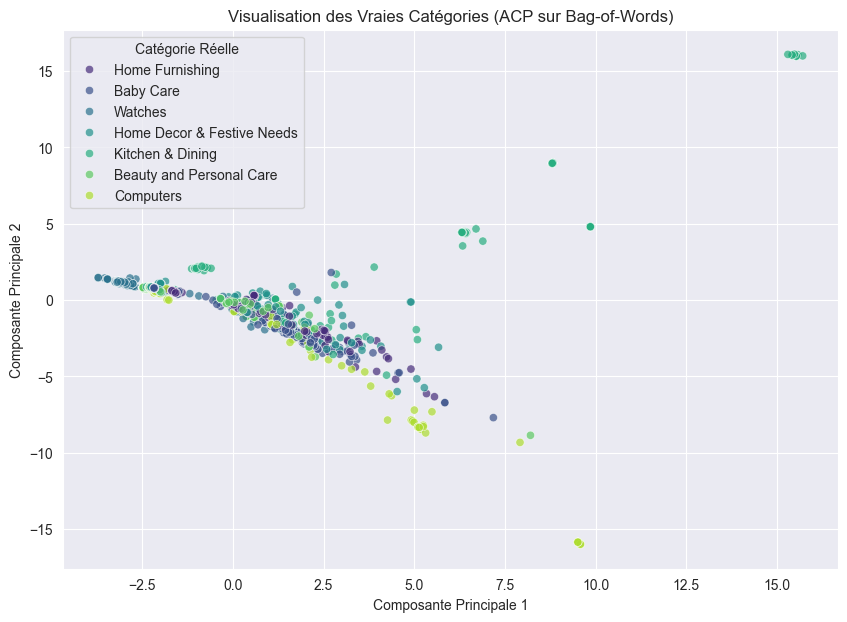

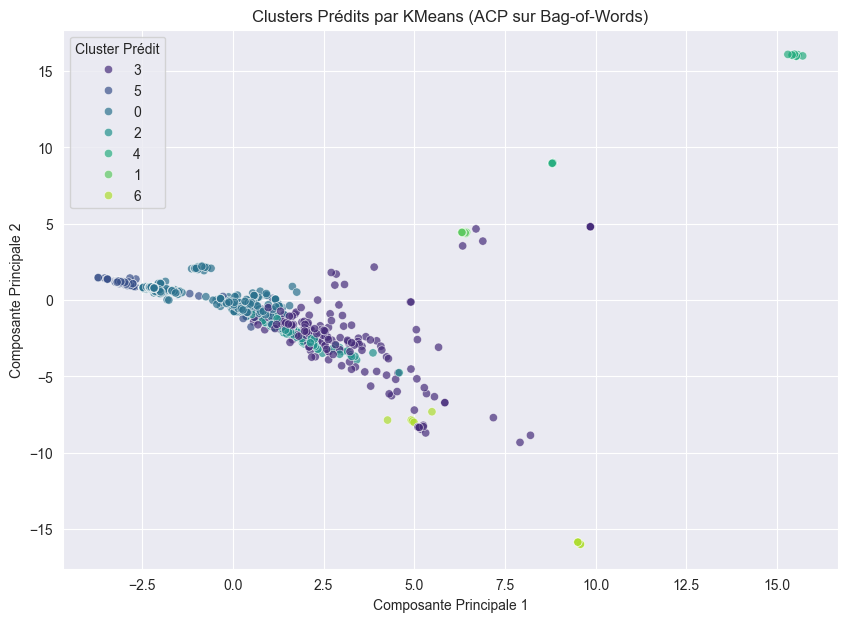

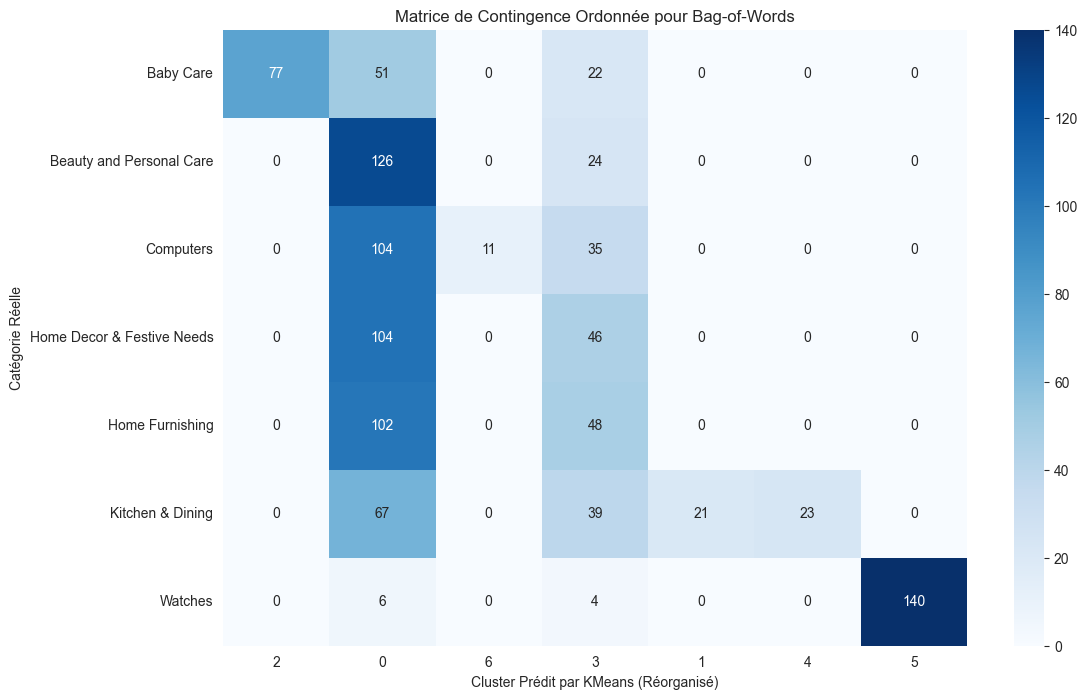

Résultats pour TF-IDF -> ARI: 0.292, NMI: 0.504
--- Analyse pour l'algorithme : TF-IDF ---


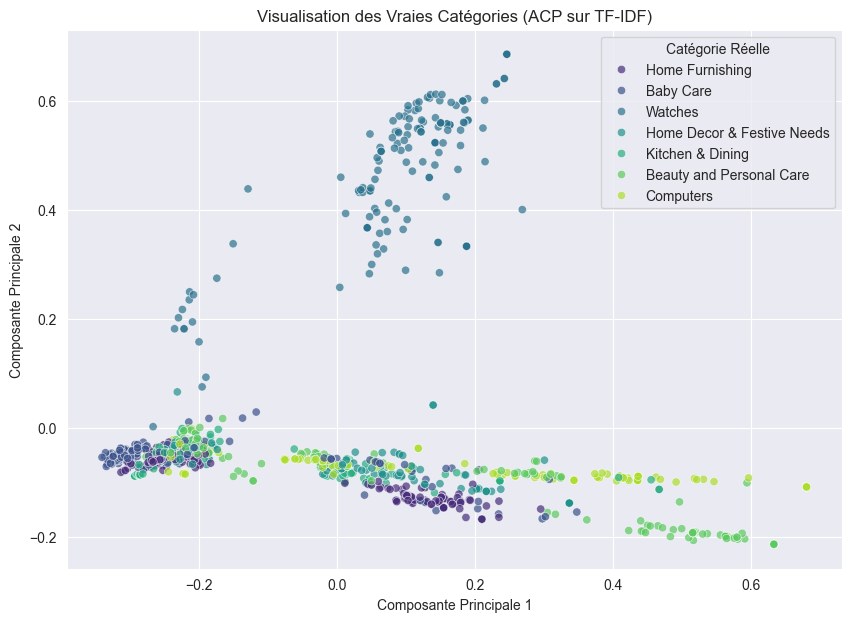

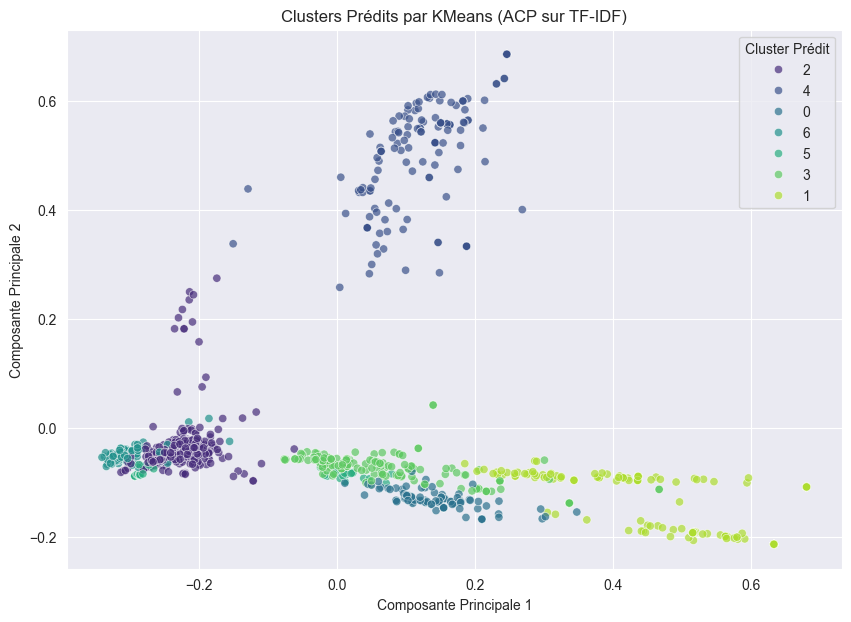

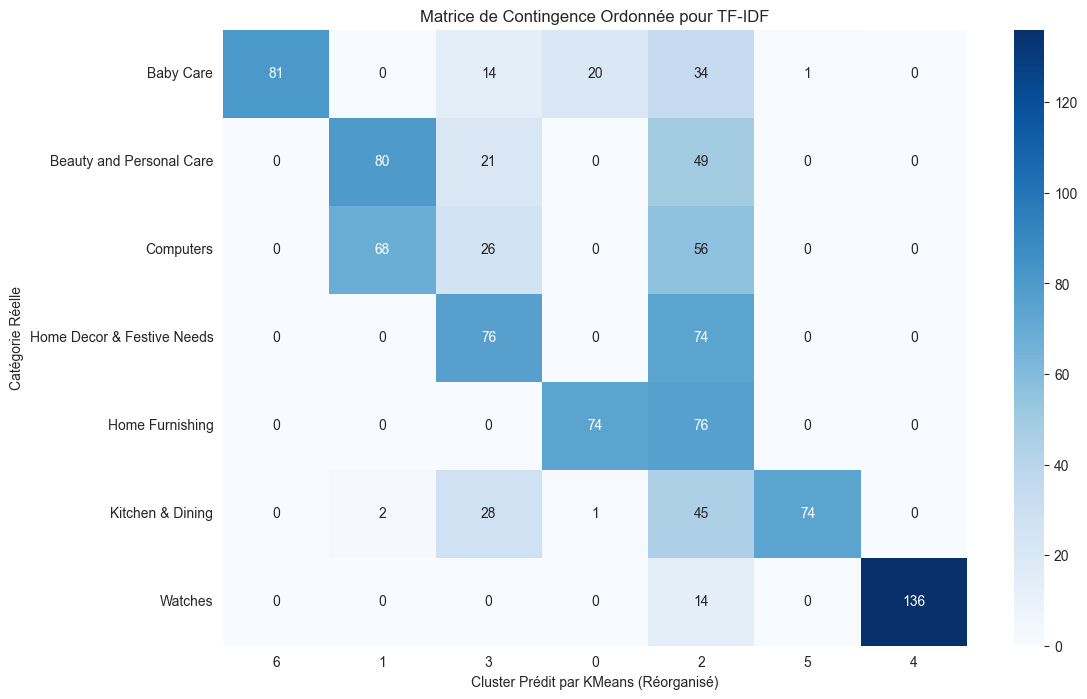

Résultats pour Word2Vec -> ARI: 0.157, NMI: 0.241
--- Analyse pour l'algorithme : Word2Vec ---


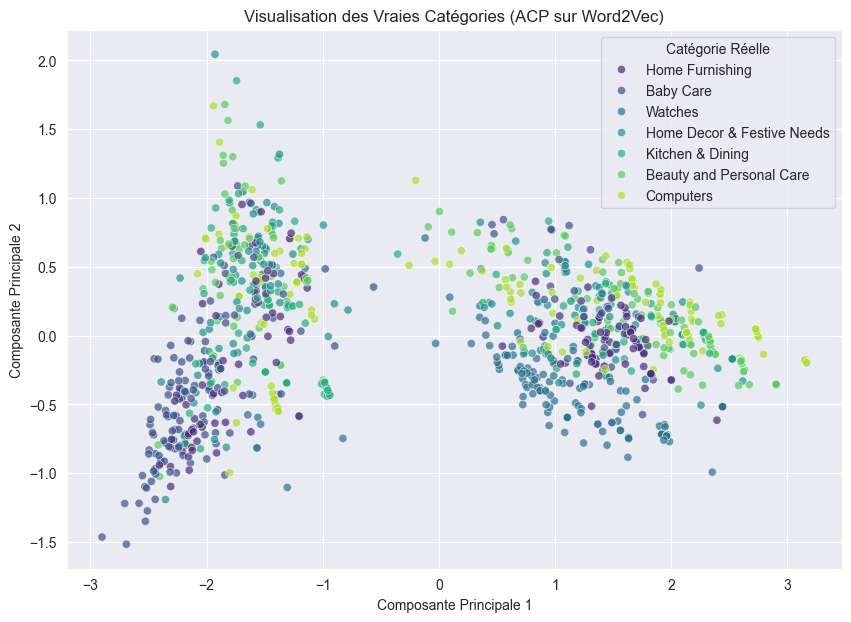

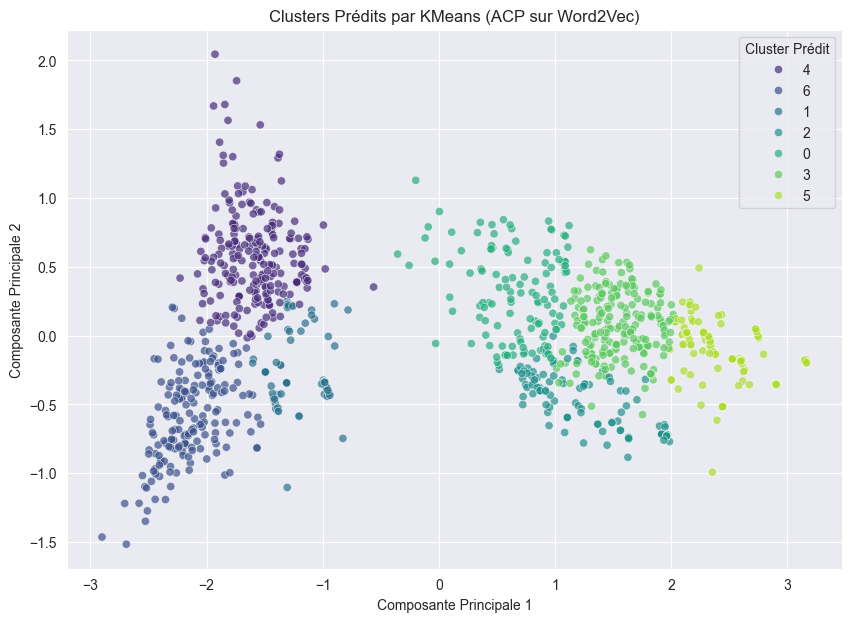

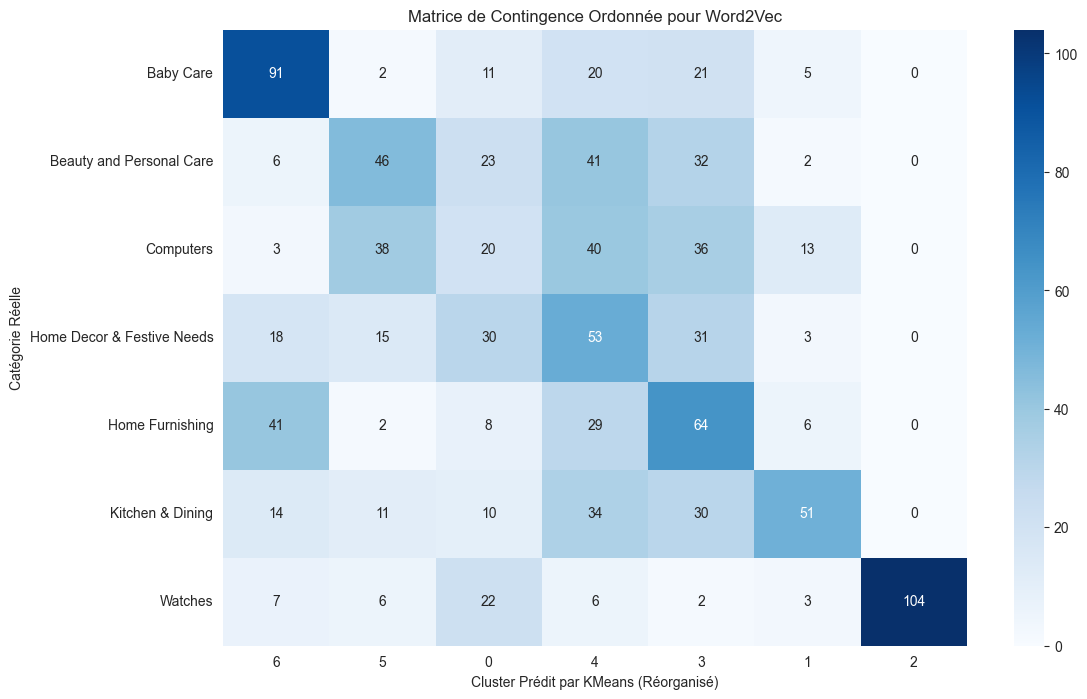

Résultats pour BERT -> ARI: 0.443, NMI: 0.581
--- Analyse pour l'algorithme : BERT ---


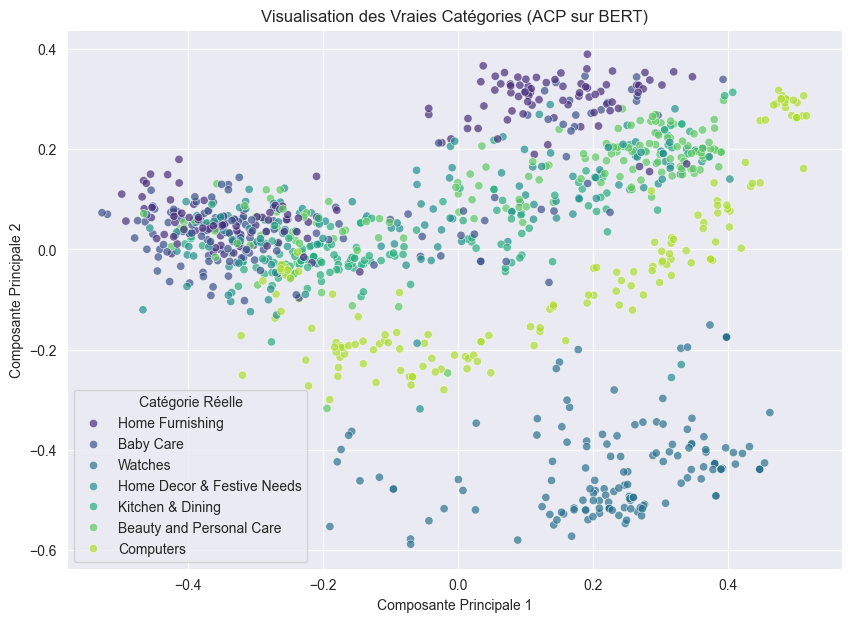

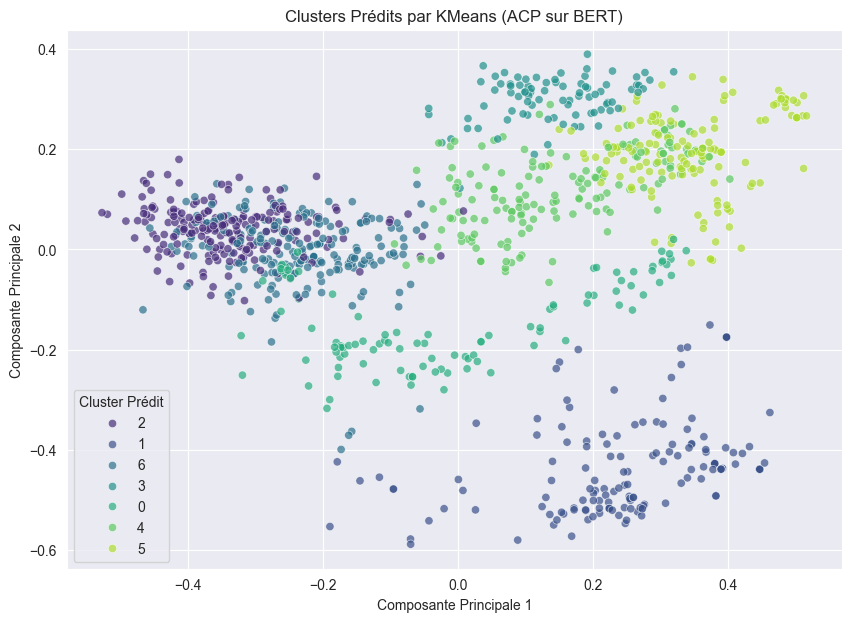

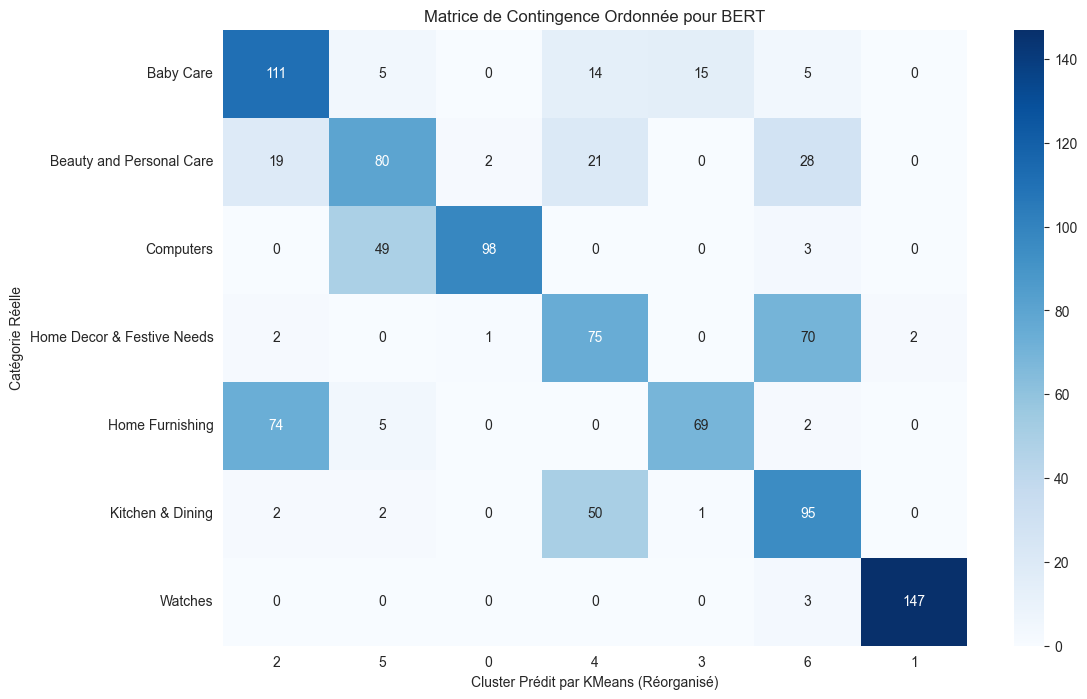

Résultats pour USE -> ARI: 0.346, NMI: 0.512
--- Analyse pour l'algorithme : USE ---


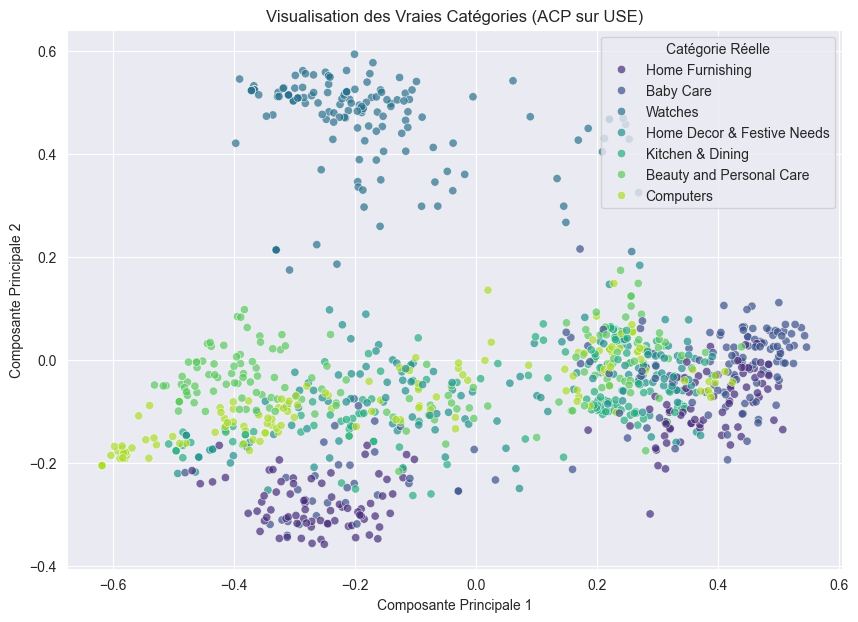

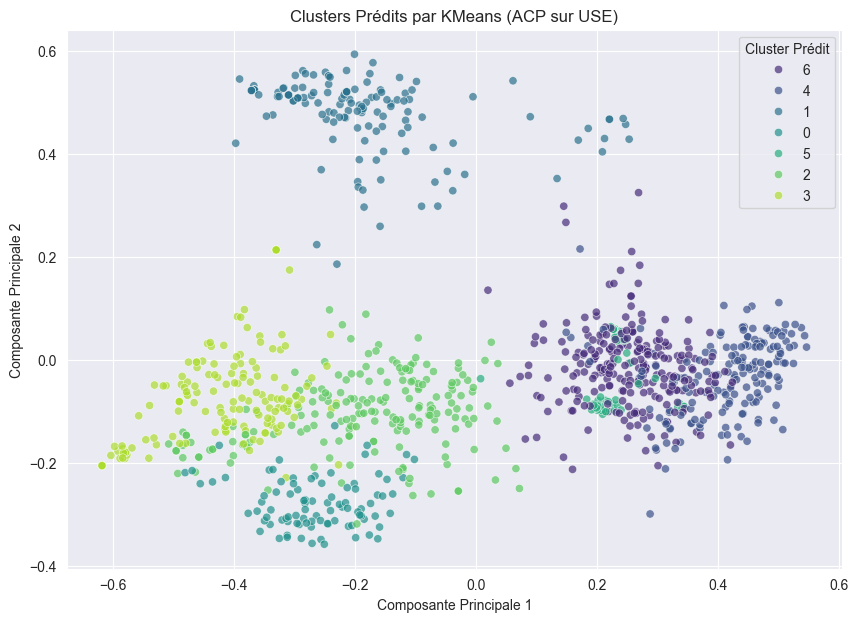

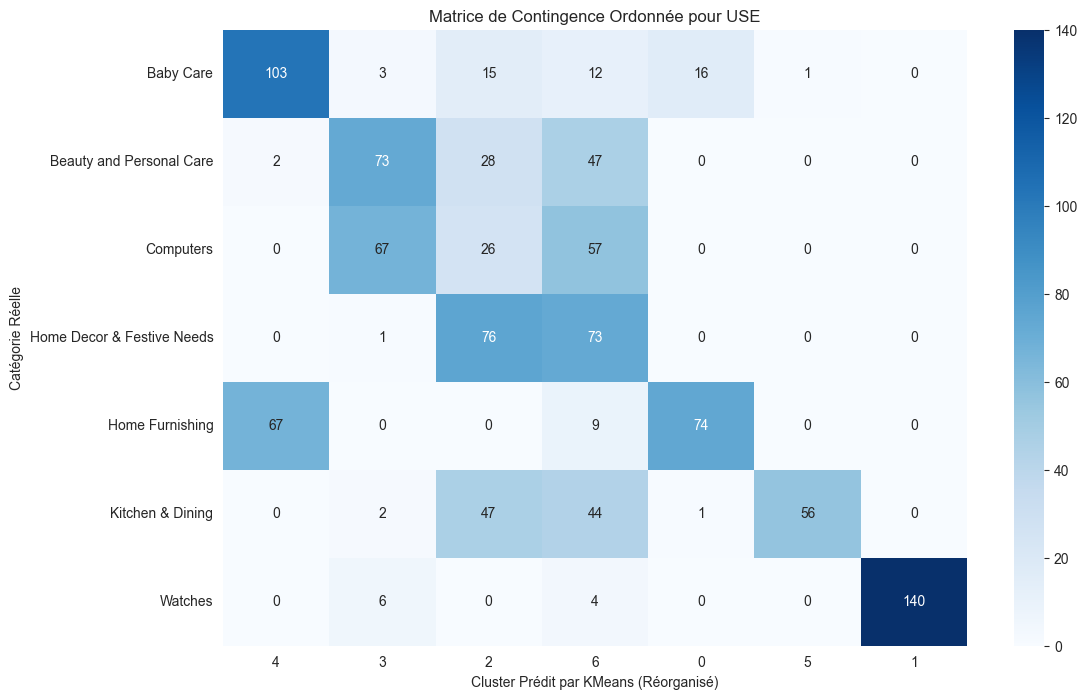

In [4]:
# 3.1 Bag-of-Words (BoW) - Sans limite de features
vectorizer_bow = CountVectorizer(ngram_range=(1, 2),max_features=2000)
features_bow = vectorizer_bow.fit_transform(texts).toarray()
evaluate_clustering(features_bow, "Bag-of-Words")
analyser_et_visualiser_clustering(features_bow, "Bag-of-Words", true_labels_str, n_clusters)

# 3.2 TF-IDF - Sans limite de features
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1, 2),max_features=2000)
features_tfidf = vectorizer_tfidf.fit_transform(texts).toarray()
evaluate_clustering(features_tfidf, "TF-IDF")
analyser_et_visualiser_clustering(features_tfidf, "TF-IDF", true_labels_str, n_clusters)

# 3.3 Word2Vec (vecteurs de taille 300)
tokenized_texts = [text.split() for text in texts]
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=300, window=5, min_count=1, workers=4)

def vectorize(sentence, model):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    return np.mean(words_vecs, axis=0) if len(words_vecs) > 0 else np.zeros(model.vector_size)

features_w2v = np.array([vectorize(text, w2v_model) for text in texts])
evaluate_clustering(features_w2v, "Word2Vec")
analyser_et_visualiser_clustering(features_w2v, "Word2Vec", true_labels_str, n_clusters)

# 3.4 BERT (via Sentence-Transformers)
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
features_bert = bert_model.encode(texts)
features_bert_for_viz = evaluate_clustering(features_bert, "BERT")
analyser_et_visualiser_clustering(features_bert, "BERT", true_labels_str, n_clusters)

# 3.5 Universal Sentence Encoder (USE)
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
features_use = use_model(texts).numpy()
evaluate_clustering(features_use, "USE")
analyser_et_visualiser_clustering(features_use, "USE", true_labels_str, n_clusters)

## 4. Conclusion de l'Étude de Faisabilité

In [5]:
df_results = pd.DataFrame(results).T.sort_values(by="ARI", ascending=False)
print("\n--- Tableau Comparatif des Performances ---")
print(df_results)


--- Tableau Comparatif des Performances ---
                   ARI       NMI
BERT          0.443089  0.580659
USE           0.346405  0.511541
TF-IDF        0.291573  0.503934
Word2Vec      0.156801  0.240547
Bag-of-Words  0.156587  0.374823


**Conclusion** : L'étude de faisabilité est un succès. Les embeddings modernes, en particulier BERT, permettent d'obtenir un score ARI de 0.44, indiquant des regroupements de produits plutôt cohérents. Cela valide la pertinence des données textuelles pour un futur modèle de classification.